#### Notes
- DATASET: Customer-level data of a leading telecom firm, 
    - Data spans over four consecutive months - June, July, August and September. 
    - First 2 months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.
- GOAL: Identify customers at high risk of churn and identify the main indicators of churn.
- Business objective: Predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In this project 
- it is primarliy Indian and Southeast Asian market.
- the usage-based definition is used to define churn.
- High-value customers are deinfed - who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase) = 29.9k rows
- Predict churn only on high-value customers.

### Strategy followed for analysis & model building
- Data understanding and exploration
- Data pre-processing
    - Filter high-value customers
    - Tag churners and remove attributes of the churn phase
    - Derive new features
    - Impute Missing value
    - Handle Outliers
    - Create Dummy variables 
- Data Preparation
    - Test train split
    - Standardise numerical values
- Dimensionality reduction (PCA)
- Predict customers who will churn - Train a variety of models and evaluate
    - Build model and evaluate
    - Use Regularization
    - Model evaluation
    - Interpretation of the model
- Identify important predictor attributes to understand indicators of churn - Logistic regression or a model from the tree family
    - Build model and evaluate 
    - Use Regularization
    - Model evaluation
    - Interpretation of the model
- Recommend strategies to manage customer churn

#### Hints
- Using techniques to handle class imbalance - stratify
- In case of logistic regression, make sure to handle multi-collinearity.

1. Impute missing values
- Dropped columns with > 70% data missing
- Dropped rows with > data missing
- numerical variables:
    - mean (for data with no outliers)
    - median (for data with outliers)
- categorical variables: mode
2. Outlier handling - Not done
3. Dummy variables - Not done
4. New features - Done

### Imports & Functions

In [1]:
import sys

import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

# For data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Calculates and returns the percentage of a value in the total
def percent(value, total):
    return round(100 * value/total, 2)  

# Display the len and columns of the df
def listColumns(df):
    print(f"{len(df.columns.tolist())} {df.columns.tolist()}")

# Get the columns with the specified prefix
def getColumnsWithPrefix(prefix, cols):
    lenPrefix = len(prefix)
    l =list(filter(lambda x: True if x[:lenPrefix]==prefix else False,cols))
    print(len(l), l)
    return l

# Get the columns with the specified suffix
def getColumnsWithSuffix(suffix,cols):
    lenSuffix = len(suffix)
    l =list(filter(lambda x: True if x[-1 * lenSuffix:]==suffix else False,cols))
    print(len(l), l)
    return l

# Get the number and percent of duplicate rows in the column
def getDuplicateRows(df, col):
    duplcate_rows = df[df[col].duplicated()][col].shape[0]
    return duplcate_rows, percent(duplcate_rows, df.shape[0])
    
# Lists the columns with missing values - col name, absolute number and percentage of cells missing in the column. 
# The columns are sorted in descending order of the number of missing values.
def listColumsWithMissingData(df, LIMIT=0):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    cols = {}
    for col in df.columns:
        if df[col].isna().any():
            missing_count = df[col].isna().sum(),percent(df[col].isna().sum(),df.shape[0])
            #print(col, missing_count)
            if missing_count[1] < LIMIT: continue
            cols[col] = missing_count
    cols = sorted(cols.items(), key=lambda x: x[1][0], reverse=True)
    #[print(f"{col[0]:15}  {col[1][0]:7d} {col[1][1]}%") for col in cols ]
    return cols

# Displays the columns with missing data using msno matrix and bar
def displayColumnsWithMissingData(df_):
    plt.figure(figsize=(10, 6 ))
    msno.matrix(df_[df_.columns[df_.isnull().any()]]);plt.show()
    msno.bar(df_[df_.columns[df_.isnull().any()]]);plt.show()

# Gets the list of columns which are categorical in nature
def getCategoricalColumns(df):
    cat_columns_ = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns = sorted(cat_columns_)
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    return cat_columns_

# For each categorical column, 
# - prints all the unique values 
# - plots the distribution of values
def plotCategoricalVariables(df_, cat_columns, title):
    COLS = 4
    count = len(cat_columns)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = cat_columns[i]
        count_values = df_[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df_[col].unique().tolist())) if np.NaN not in df_[col].unique().tolist() else (df_[col].unique().tolist())}")
        df__ = (df_[[col]].value_counts(normalize=True)*100)#.to_frame()
        #df__.reset_index(drop=True, inplace=True)
        #df__[col] = df__[col].astype(int)
        #print(df__.head())
        plt.subplot(rows, COLS, i+1);ax=df__.plot.bar();_ = plt.xticks(rotation=0); annotate(ax)
    fig.suptitle(title, fontsize=14)

# Gets the list of columns which are numerical in nature
def getNumericalColumns(df):
    num_columns_ = df.select_dtypes(include=[np.float, np.int64]).columns.tolist()
    num_columns_ = sorted(num_columns_)
    print(f"Columns with numerical values {len(num_columns_)} --> {num_columns_}")
    return num_columns_ 

# For each numerical column, 
# - prints all the unique values (if <30), else prints 10 values
# - plots the distribution of values - distplot (for columns with >30 unique values) or histplot (for columns with <30 unique values)
def plotNumericalVariables(df_, num_cols, title):
    COLS = 4
    count = len(num_cols)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = num_cols[i]
        count_values = df_[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.distplot(df_[col])
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 
            #ax=df[col].plot.hist(weights=np.ones(df.shape[0]) / df.shape[0]);annotate(ax, title=col);plt.show()
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.histplot(data=df_[col])

    fig.suptitle(title, fontsize=14)

# Plot the box plots for the specified numerical columns
def plotBoxPlots(df_, num_cols):
    COLS = 6
    count = len(num_cols)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = num_cols[i]
        plt.subplot(rows, COLS, i+1);sns.boxplot(y=df_[col])

    fig.suptitle("", fontsize=14)

# Converts the category to a ordinal numerical label
def clategoryToOridnalLabel(X, cat):
    oe = preprocessing.OrdinalEncoder(categories=cat)
    oe.fit(X)
    print(oe.categories_)
    X1 = oe.transform(X)
    #print(X1[:5])
    return X1
    #print(oe.feature_names_in_)

# Creates dummies for categorical columns and returns the combined dataframe
# The categorical column should be dropped.
def addDummies(df, col, dropcat, df_out):
    print(f"[{col}] Before: {df_out.columns.shape[0]}", end=' ')
    temp = pd.get_dummies(df[col], prefix=col, drop_first=True)
    #df.drop(columns=[col], inplace=True)
    #temp = temp.drop([dropcat], 1)
    #Adding the results to the master dataframe
    df_out = pd.concat([df_out, temp], axis=1)
    print(f"After: {df_out.columns.shape[0]}", end=' ')
    print()
    return df_out

# Annotates the bars
def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

# Read the dataset

In [3]:
df = pd.read_csv("telecom_churn_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [5]:
listColumns(df)

226 ['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m

Do we need to handle missing values for 
- PCA?
- decision trees/random forest? 

In [6]:
COLS= df.columns.tolist()
COLS_ID = ['mobile_number']
COLS_LOC = getColumnsWithPrefix('loc',COLS) # LOCAL
COLS_STD = getColumnsWithPrefix('std',COLS)
COLS_ISD = getColumnsWithPrefix('isd',COLS)
COLS_LAST_DATE = getColumnsWithPrefix('last_date_',COLS)
COLS_DATE = getColumnsWithPrefix('date_',COLS)
COLS_ARPU = getColumnsWithPrefix('arpu',COLS)
COLS_ONNET = getColumnsWithPrefix('onnet',COLS)
COLS_OFFNET = getColumnsWithPrefix('offnet',COLS)
COLS_ROAM = getColumnsWithPrefix('roam',COLS)
COLS_SPL = getColumnsWithPrefix('spl',COLS)
COLS_OG = getColumnsWithPrefix('og',COLS)
COLS_IC = getColumnsWithPrefix('ic',COLS)
COLS_TOTAL = getColumnsWithPrefix('total',COLS)
COLS_MAX = getColumnsWithPrefix('max',COLS)
COLS_COUNT = getColumnsWithPrefix('count',COLS)
COLS_AV = getColumnsWithPrefix('av',COLS)
COLS_VOL = getColumnsWithPrefix('vol',COLS)
COLS_NIGHT = getColumnsWithPrefix('night',COLS)
COLS_MONTH = getColumnsWithPrefix('monthly',COLS)
COLS_SACHET = getColumnsWithPrefix('sachet',COLS)
COLS_FB = getColumnsWithPrefix('fb_user',COLS)
COLS_4_MON = getColumnsWithPrefix('jun',COLS) + getColumnsWithPrefix('jul',COLS) + getColumnsWithPrefix('aug',COLS) + getColumnsWithPrefix('sep',COLS)

38 ['loc_og_t2o_mou', 'loc_ic_t2o_mou', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9']
41 ['std_og_t2o_mou', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_t2

In [7]:
df[COLS_LAST_DATE].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014


In [8]:
df[COLS_DATE].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [9]:
COLS_CAT = getCategoricalColumns(df)

Columns with categorical values 12 --> ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9']


In [10]:
df[COLS_CAT].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [11]:
COLS_NUM = getNumericalColumns(df)

Columns with numerical values 214 --> ['aon', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'aug_vbc_3g', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'circle_id', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'ic_others_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_ic_mou_9', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'isd_og_mou_9', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'last_day_rch_amt_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'lo

# Filter high value customers

```High-value customers``` are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After filtering the high-value customers, you should get about 29.9k rows.

In [12]:
print(list(filter(lambda x: True if 'rech_amt' in x else False, COLS)))

['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [13]:
# The average recharge amount in the good phase (months 6 & 7) is in the columns 'total_rech_amt_6', 'total_rech_amt_7'. Check if there is missing data
df[['total_rech_amt_6', 'total_rech_amt_7']].isnull().sum()

total_rech_amt_6    0
total_rech_amt_7    0
dtype: int64

The  columns 'total_rech_amt_6', 'total_rech_amt_7' do not have any missing data. So we can proceed to calculate the high-value customers

In [14]:
# Store the average recharge amount in the good phase (months 6 & 7) in the column 'avg_rech_amt_67'
df['avg_rech_amt_67'] = (df['total_rech_amt_6'] + df['total_rech_amt_7'])/2
print("Average recharge amount:");print(df[['total_rech_amt_6', 'total_rech_amt_7', 'avg_rech_amt_67']].head())

# Calculate the 70th percentile of the average recharge amount in the good phase (months 6 & 7)
PC_70_AVG_RECH_AMT = df['avg_rech_amt_67'].quantile([.7]).values[0]; print('\nPC_70_AVG_RECH_AMT:', PC_70_AVG_RECH_AMT)

# Drop all the rows with avg_rech_amt_67 below 70th percentile. Retain only the high value customers
print("Number of rows > PC_70_AVG_RECH_AMT:", df[df['avg_rech_amt_67']>PC_70_AVG_RECH_AMT].shape[0])
print("Number of rows >= PC_70_AVG_RECH_AMT:", df[df['avg_rech_amt_67']>=PC_70_AVG_RECH_AMT].shape[0])
df = df[df['avg_rech_amt_67']>PC_70_AVG_RECH_AMT]
print("Number of rows retained in df:", df.shape[0])

Average recharge amount:
   total_rech_amt_6  total_rech_amt_7  avg_rech_amt_67
0               362               252            307.0
1                74               384            229.0
2               168               315            241.5
3               230               310            270.0
4               196               350            273.0

PC_70_AVG_RECH_AMT: 368.5
Number of rows > PC_70_AVG_RECH_AMT: 29979
Number of rows >= PC_70_AVG_RECH_AMT: 30011
Number of rows retained in df: 29979


In [15]:
df.shape

(29979, 227)

# Tag the churners

Step1: Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

Step2: After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [16]:
COLS_USAGE = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
print(df[COLS_USAGE].shape[0])
print(df[COLS_USAGE].isnull().sum())

29979
total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64


None of the columns needed to tag having data. So we can proceed without further processing

In [17]:
# Find the number of rows where each of the columns are 0
df[df['total_ic_mou_9']==0].shape[0], df[df['total_og_mou_9']==0].shape[0],df[df['vol_2g_mb_9']==0].shape[0], df[df['vol_3g_mb_9']==0].shape[0]

(2937, 3245, 20678, 22801)

In [18]:
# Find all the rows where the churn columns are 0 - no calls & no mobile internet usage
CHURN_CONDITION = (df['total_ic_mou_9']==0) & (df['total_og_mou_9']==0) & (df['vol_2g_mb_9']==0) & (df['vol_3g_mb_9']==0)
df[CHURN_CONDITION].shape[0]

2589

In [19]:
# Tag the customers with all churn columns 0 - no calls & no mobile internet usage
COL_TARGET = 'churn'
print("Columns:", len(df.columns.tolist()), end=' --> ')
df[COL_TARGET] = 0
df.loc[CHURN_CONDITION, 'churn'] = 1

Columns: 227 --> 

NOTE: We will do the step2 (remove the columns of month 9) after exploring how the customer behaviour is across various phases

In [20]:
print(len(df.columns.tolist())); print((100*df[COL_TARGET].value_counts(normalize=True)).round(2))

228
0    91.36
1     8.64
Name: churn, dtype: float64


The target variable ```churn``` is imbalanced with 91% no churn and 9% churn data points.

|   | | Predicted|  |
|---|---|---|---|
||   | 0  | 1  |
| Actual | 0 | TN   | FP  |
| | 1 |  FN |  TP |

- **False Positive (FP)**: Predicted "Churn" but was "No Churn"
- **False Negative (FN)**: Predicted "No Churn" but was "Churn" --> We would like this to be as low as possible because lot of genuine high value customers who could churn will not be addressed 

So, the evaluation metric for the classification models would be **Recall**=TP/(TP+FN)


In [21]:
df.shape

(29979, 228)

# Explore

### Identify columns with missing data

<Figure size 720x432 with 0 Axes>

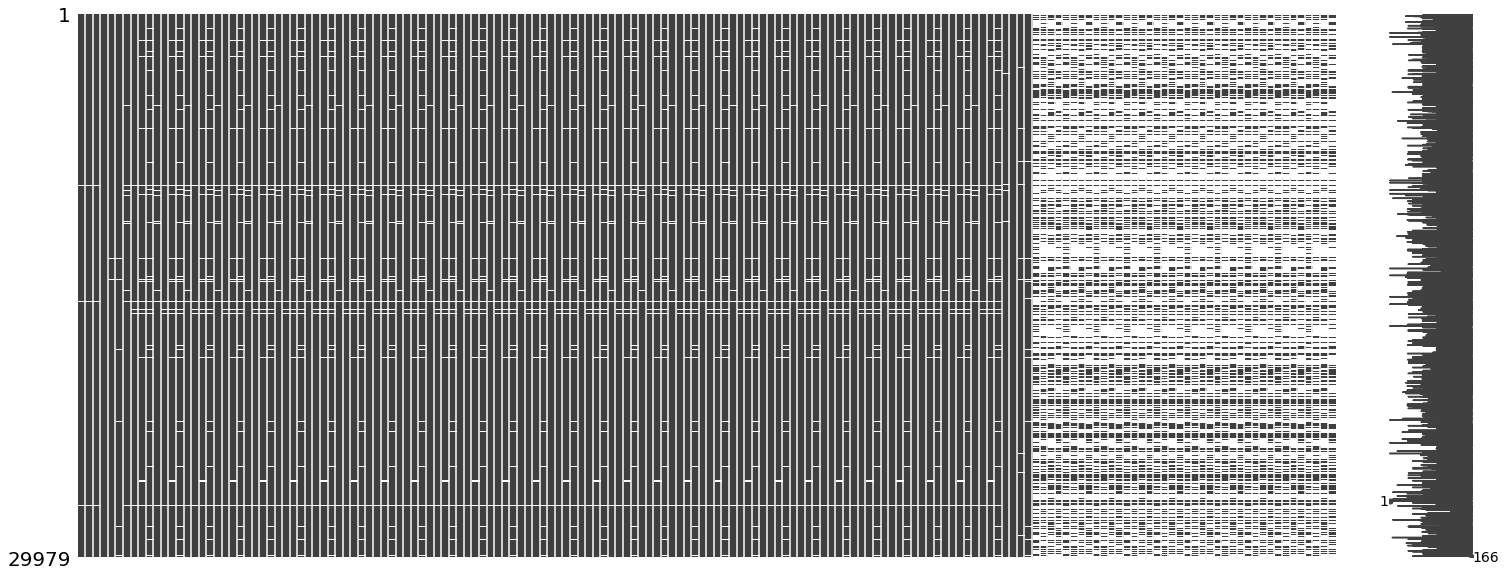

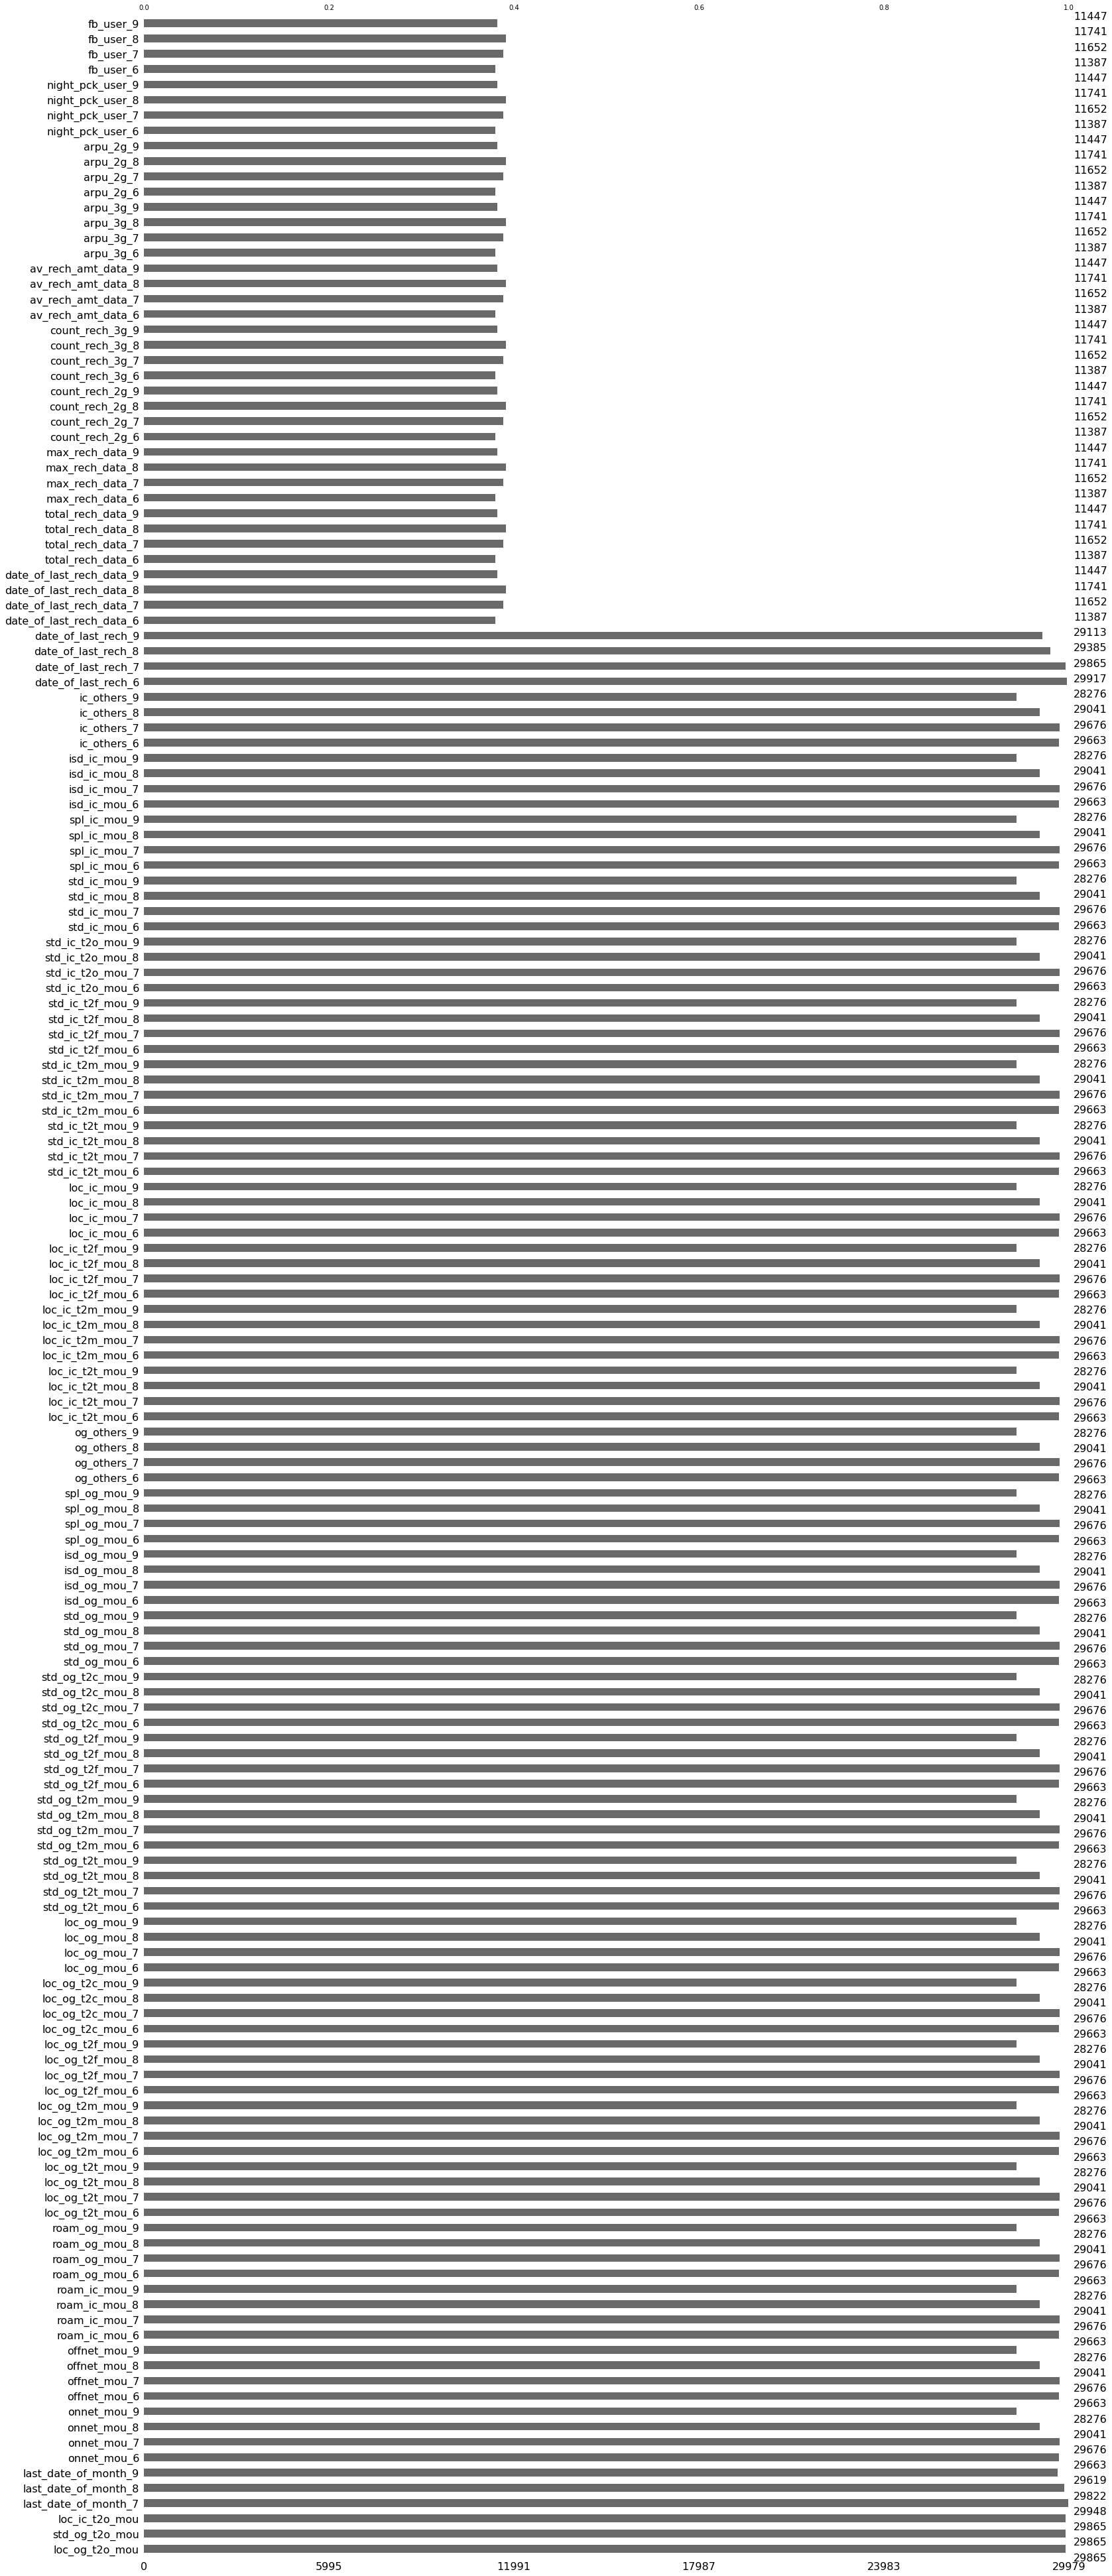

Columns with missing data: 166 72.81%


[('date_of_last_rech_data_6', (18592, 62.02)),
 ('total_rech_data_6', (18592, 62.02)),
 ('max_rech_data_6', (18592, 62.02)),
 ('count_rech_2g_6', (18592, 62.02)),
 ('count_rech_3g_6', (18592, 62.02)),
 ('av_rech_amt_data_6', (18592, 62.02)),
 ('arpu_3g_6', (18592, 62.02)),
 ('arpu_2g_6', (18592, 62.02)),
 ('night_pck_user_6', (18592, 62.02)),
 ('fb_user_6', (18592, 62.02)),
 ('date_of_last_rech_data_9', (18532, 61.82)),
 ('total_rech_data_9', (18532, 61.82)),
 ('max_rech_data_9', (18532, 61.82)),
 ('count_rech_2g_9', (18532, 61.82)),
 ('count_rech_3g_9', (18532, 61.82)),
 ('av_rech_amt_data_9', (18532, 61.82)),
 ('arpu_3g_9', (18532, 61.82)),
 ('arpu_2g_9', (18532, 61.82)),
 ('night_pck_user_9', (18532, 61.82)),
 ('fb_user_9', (18532, 61.82)),
 ('date_of_last_rech_data_7', (18327, 61.13)),
 ('total_rech_data_7', (18327, 61.13)),
 ('max_rech_data_7', (18327, 61.13)),
 ('count_rech_2g_7', (18327, 61.13)),
 ('count_rech_3g_7', (18327, 61.13)),
 ('av_rech_amt_data_7', (18327, 61.13)),
 ('a

In [22]:
displayColumnsWithMissingData(df)
listColumsWithMissingData(df)

In [23]:
cols_miss_ = listColumsWithMissingData(df, 40)
cols_miss = [col[0] for col in cols_miss_]
print("Columns with more than 40% missing data:", cols_miss)#;[print(col, end=', ') for col in COLS_MISS]; print()

Columns with missing data: 166 72.81%
Columns with more than 40% missing data: ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'fb_user_9', 'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7', 'date_of_last_rech_data_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_3g_8', 'arpu_2g_8', 'night_pck_user_8', 'fb_user_8']


We should drop all these columns. Let's add the columns to drop to COLS_TO_DROP

In [24]:
COLS_TO_DROP = cols_miss

### Identify columns of Id type and with all same value

In [25]:
for col in COLS_CAT:
    duplicate_rows_num, duplicate_rows_pc = getDuplicateRows(df,col)
    print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {df[col].value_counts(normalize=True).shape[0]}")

last_date_of_month_6: Duplicates 29978, 100.0 Unique values: 1
last_date_of_month_7: Duplicates 29977, 99.99 Unique values: 1
last_date_of_month_8: Duplicates 29977, 99.99 Unique values: 1
last_date_of_month_9: Duplicates 29977, 99.99 Unique values: 1
date_of_last_rech_6: Duplicates 29948, 99.9 Unique values: 30
date_of_last_rech_7: Duplicates 29947, 99.89 Unique values: 31
date_of_last_rech_8: Duplicates 29947, 99.89 Unique values: 31
date_of_last_rech_9: Duplicates 29948, 99.9 Unique values: 30
date_of_last_rech_data_6: Duplicates 29948, 99.9 Unique values: 30
date_of_last_rech_data_7: Duplicates 29947, 99.89 Unique values: 31
date_of_last_rech_data_8: Duplicates 29947, 99.89 Unique values: 31
date_of_last_rech_data_9: Duplicates 29948, 99.9 Unique values: 30


In [26]:
print("Duplicates in mobile_number:", getDuplicateRows(df, 'mobile_number'))
print("Duplicates in circle_id:", getDuplicateRows(df, 'circle_id'))

Duplicates in mobile_number: (0, 0.0)
Duplicates in circle_id: (29978, 100.0)


In [27]:
cols_all_same_value = []
cols_less_unique_values = []
cols_all_unique = []
for col in COLS:
    duplicate_rows_num, duplicate_rows_pc = getDuplicateRows(df,col)
    unique_values = df[col].value_counts().index.tolist()
    unique_rows_num = len(unique_values) #df[col].value_counts(normalize=True).shape[0]
    if unique_rows_num == 1:
        print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {unique_rows_num} ")
        cols_all_same_value.append(col)
    elif duplicate_rows_num == 0:
        cols_all_unique.append(col)
    elif unique_rows_num < 3:
        print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {unique_rows_num} {unique_values}")
        cols_less_unique_values.append(col)
    #print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {df[col].value_counts(normalize=True).shape[0]}")

print();print('COLS_ALL_UNIQUE', cols_all_unique)
print('COLS_ALL_SAME_VALUE', cols_all_same_value)
print('COLS_LESS_UNIQUE_VALUES', cols_less_unique_values)

circle_id: Duplicates 29978, 100.0 Unique values: 1 
loc_og_t2o_mou: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2o_mou: Duplicates 29977, 99.99 Unique values: 1 
loc_ic_t2o_mou: Duplicates 29977, 99.99 Unique values: 1 
last_date_of_month_6: Duplicates 29978, 100.0 Unique values: 1 
last_date_of_month_7: Duplicates 29977, 99.99 Unique values: 1 
last_date_of_month_8: Duplicates 29977, 99.99 Unique values: 1 
last_date_of_month_9: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2c_mou_6: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2c_mou_7: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2c_mou_8: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2c_mou_9: Duplicates 29977, 99.99 Unique values: 1 
std_ic_t2o_mou_6: Duplicates 29977, 99.99 Unique values: 1 
std_ic_t2o_mou_7: Duplicates 29977, 99.99 Unique values: 1 
std_ic_t2o_mou_8: Duplicates 29977, 99.99 Unique values: 1 
std_ic_t2o_mou_9: Duplicates 29977, 99.99 Unique values: 1 
night_pck_user_6: Duplicates 29976, 9

- Mobile number is unique for all rows. This should be dropped for model building.
- As all the rows for the COLS_ALL_SAME_VALUE columns have the same value. We can drop these.
Let's append these to the COLS_TO_DROP

In [28]:
print("Before: ", len(COLS_TO_DROP), COLS_TO_DROP)
COLS_TO_DROP.extend(cols_all_same_value)
COLS_TO_DROP.extend(cols_all_unique)
print();print("After: ", len(COLS_TO_DROP), COLS_TO_DROP)

Before:  40 ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'fb_user_9', 'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7', 'date_of_last_rech_data_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_3g_8', 'arpu_2g_8', 'night_pck_user_8', 'fb_user_8']

After:  57 ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech

### Handle Missing data

Drop the columns in COLS_TO_DROP - columns with 
- > 40% missing data
- all same data
- all unique data

In [29]:
print("DF SHAPE", df.shape, end='')
df.drop(columns=COLS_TO_DROP, inplace=True); df.reset_index(drop=True, inplace=True)
print("-->", df.shape)

DF SHAPE (29979, 228)--> (29979, 171)


Drop rows with > 80% missing data

In [30]:
df_row_gt_80_miss = df[df.isna().sum(axis="columns") > 80]
df_row_gt_80_miss.shape[0], 100 * df_row_gt_80_miss.shape[0]/df.shape[0]

(254, 0.8472597484906101)

There are 254 rows i.e. <1% rows with > 80% data missing. Let's drop this

In [31]:
print("DF SHAPE", df.shape, end='-->')
df.drop(df_row_gt_80_miss.index, inplace=True);df.reset_index(drop=True, inplace=True)
print(df.shape)

DF SHAPE (29979, 171)-->(29725, 171)


<Figure size 720x432 with 0 Axes>

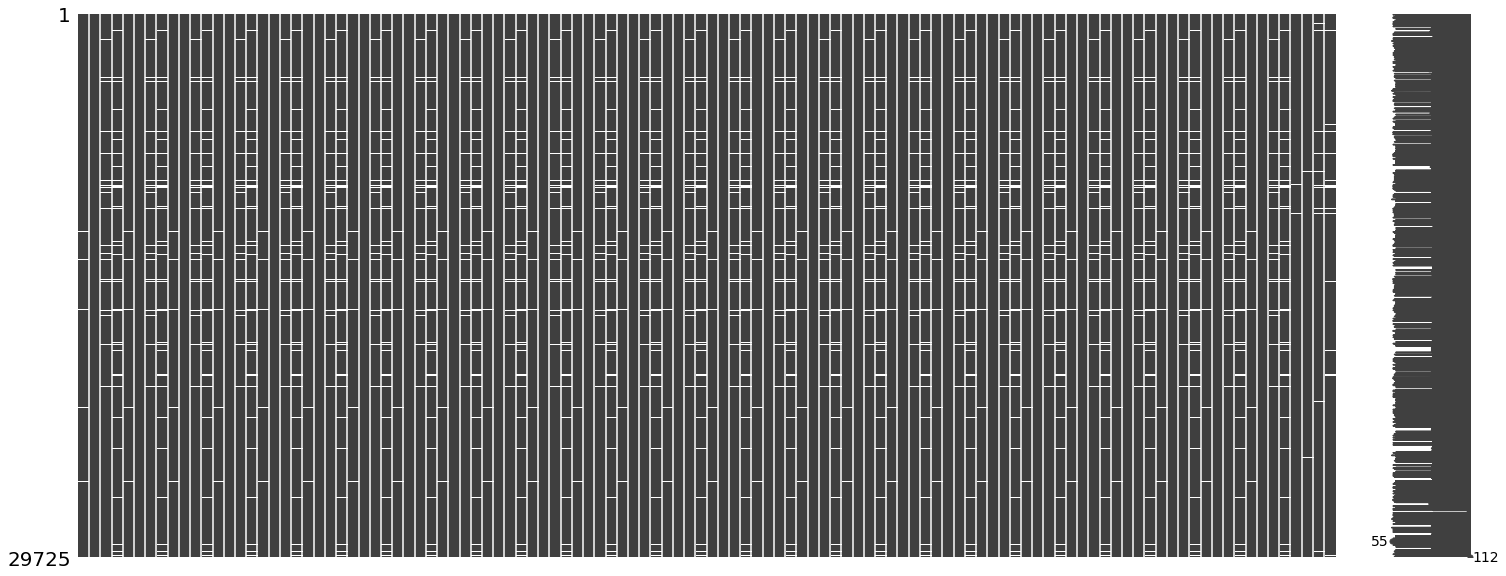

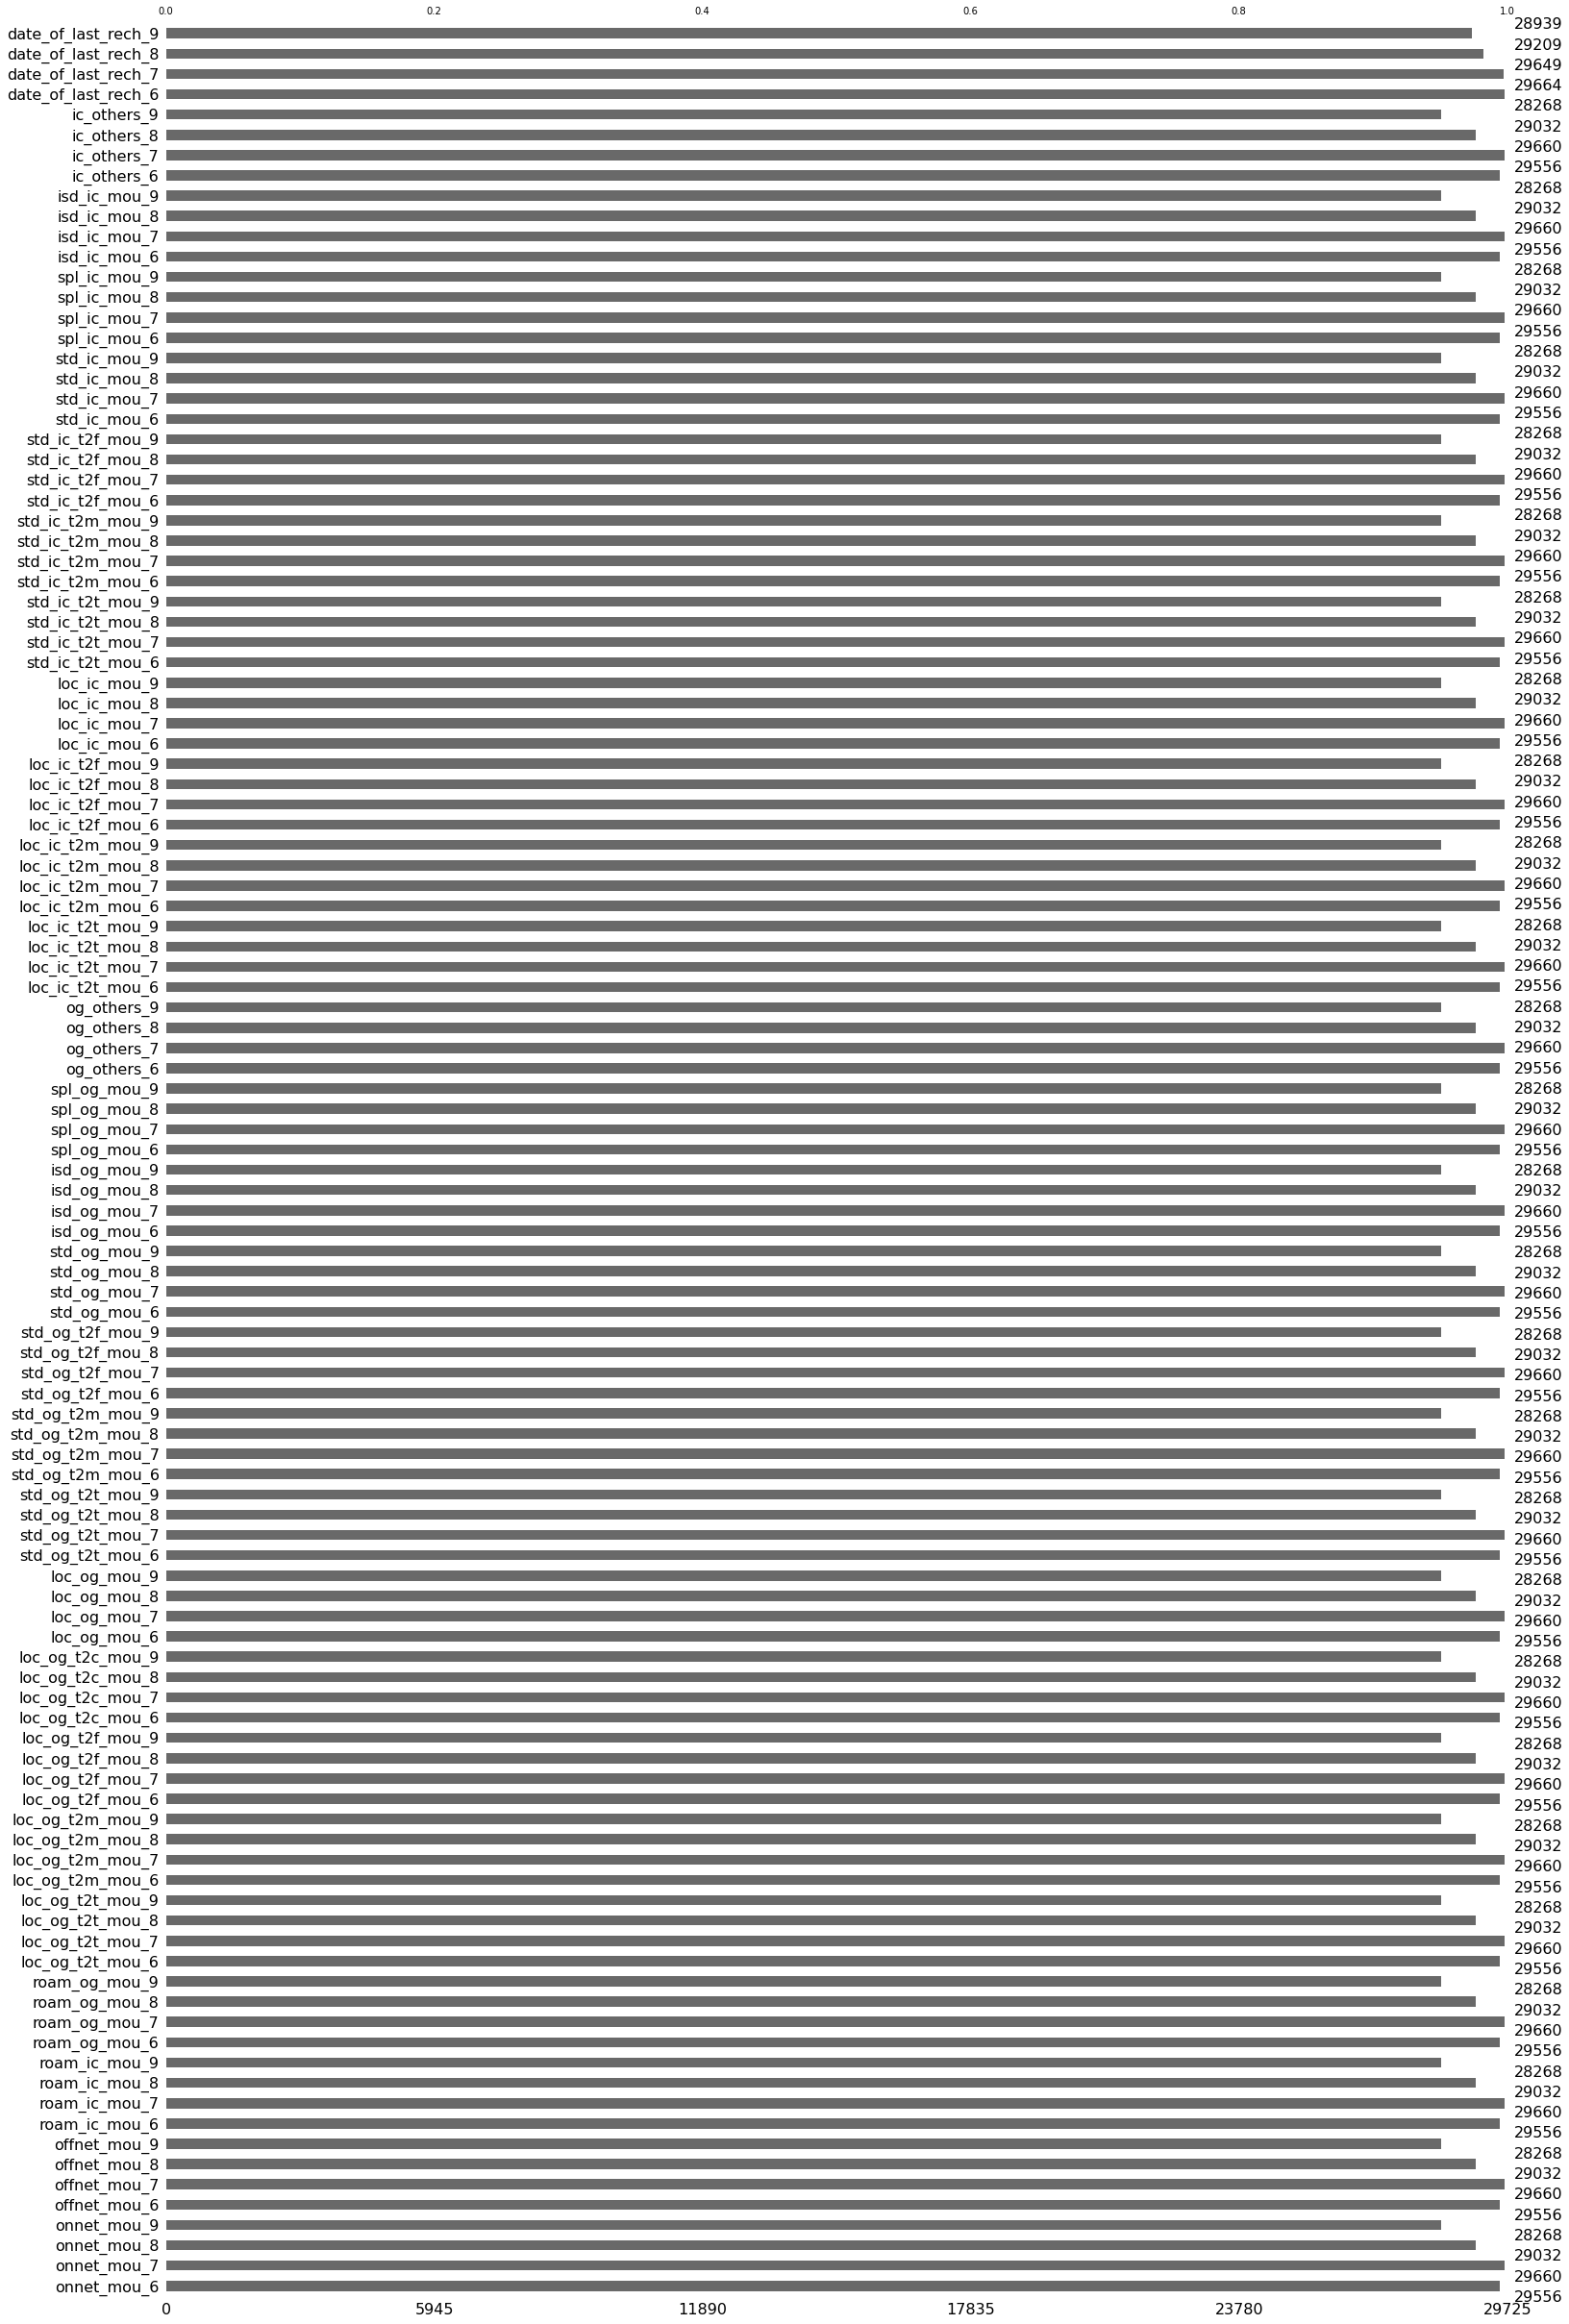

Columns with missing data: 112 65.5%
onnet_mou_9, offnet_mou_9, roam_ic_mou_9, roam_og_mou_9, loc_og_t2t_mou_9, loc_og_t2m_mou_9, loc_og_t2f_mou_9, loc_og_t2c_mou_9, loc_og_mou_9, std_og_t2t_mou_9, std_og_t2m_mou_9, std_og_t2f_mou_9, std_og_mou_9, isd_og_mou_9, spl_og_mou_9, og_others_9, loc_ic_t2t_mou_9, loc_ic_t2m_mou_9, loc_ic_t2f_mou_9, loc_ic_mou_9, std_ic_t2t_mou_9, std_ic_t2m_mou_9, std_ic_t2f_mou_9, std_ic_mou_9, spl_ic_mou_9, isd_ic_mou_9, ic_others_9, date_of_last_rech_9, onnet_mou_8, offnet_mou_8, roam_ic_mou_8, roam_og_mou_8, loc_og_t2t_mou_8, loc_og_t2m_mou_8, loc_og_t2f_mou_8, loc_og_t2c_mou_8, loc_og_mou_8, std_og_t2t_mou_8, std_og_t2m_mou_8, std_og_t2f_mou_8, std_og_mou_8, isd_og_mou_8, spl_og_mou_8, og_others_8, loc_ic_t2t_mou_8, loc_ic_t2m_mou_8, loc_ic_t2f_mou_8, loc_ic_mou_8, std_ic_t2t_mou_8, std_ic_t2m_mou_8, std_ic_t2f_mou_8, std_ic_mou_8, spl_ic_mou_8, isd_ic_mou_8, ic_others_8, date_of_last_rech_8, onnet_mou_6, offnet_mou_6, roam_ic_mou_6, roam_og_mou_6, loc_og

[('onnet_mou_9', (1457, 4.9)),
 ('offnet_mou_9', (1457, 4.9)),
 ('roam_ic_mou_9', (1457, 4.9)),
 ('roam_og_mou_9', (1457, 4.9)),
 ('loc_og_t2t_mou_9', (1457, 4.9)),
 ('loc_og_t2m_mou_9', (1457, 4.9)),
 ('loc_og_t2f_mou_9', (1457, 4.9)),
 ('loc_og_t2c_mou_9', (1457, 4.9)),
 ('loc_og_mou_9', (1457, 4.9)),
 ('std_og_t2t_mou_9', (1457, 4.9)),
 ('std_og_t2m_mou_9', (1457, 4.9)),
 ('std_og_t2f_mou_9', (1457, 4.9)),
 ('std_og_mou_9', (1457, 4.9)),
 ('isd_og_mou_9', (1457, 4.9)),
 ('spl_og_mou_9', (1457, 4.9)),
 ('og_others_9', (1457, 4.9)),
 ('loc_ic_t2t_mou_9', (1457, 4.9)),
 ('loc_ic_t2m_mou_9', (1457, 4.9)),
 ('loc_ic_t2f_mou_9', (1457, 4.9)),
 ('loc_ic_mou_9', (1457, 4.9)),
 ('std_ic_t2t_mou_9', (1457, 4.9)),
 ('std_ic_t2m_mou_9', (1457, 4.9)),
 ('std_ic_t2f_mou_9', (1457, 4.9)),
 ('std_ic_mou_9', (1457, 4.9)),
 ('spl_ic_mou_9', (1457, 4.9)),
 ('isd_ic_mou_9', (1457, 4.9)),
 ('ic_others_9', (1457, 4.9)),
 ('date_of_last_rech_9', (786, 2.64)),
 ('onnet_mou_8', (693, 2.33)),
 ('offnet_mou_8

In [32]:
displayColumnsWithMissingData(df)
cols_miss = listColumsWithMissingData(df, 0)
[print(col[0], end=', ') for col in cols_miss];print()
cols_miss

There is still missing data. But the missing data is < 5%. Let us explore the data and decide how to impute this missing data

### Explore

Let's see how the usage and revenue patterns differ between the customers who churn and who do not.

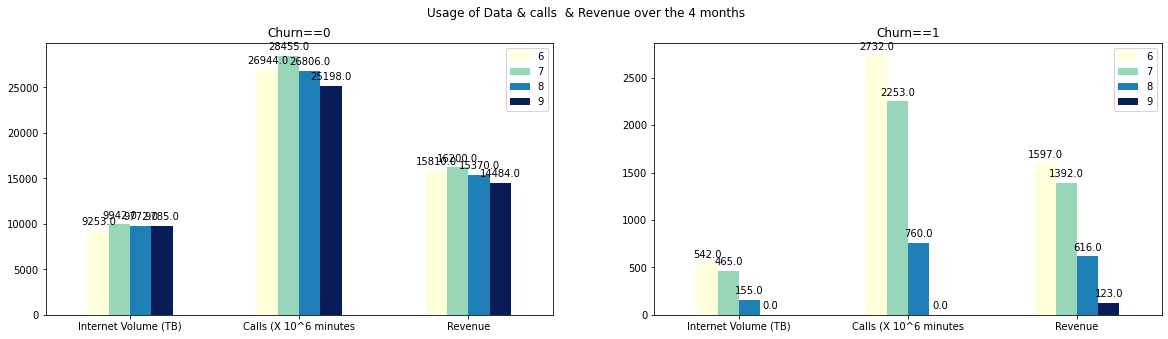

In [33]:
cols_ = ['vol_2g_mb', 'vol_3g_mb', 'total_ic_mou', 'total_og_mou', 'arpu']

df_0 = pd.DataFrame(columns=cols_) 
df_1 = pd.DataFrame(columns=cols_)
for mon in [6, 7, 8, 9]:
    for col in cols_:
        #print(mon, f'{col}_{mon}', int(df[f'{col}_{mon}'].sum()))
        df_0.loc[f'{mon}', col] = int(df[df['churn']==0][f'{col}_{mon}'].sum()/1000)
        df_1.loc[f'{mon}', col] = int(df[df['churn']==1][f'{col}_{mon}'].sum()/1000)


LABELS_USAGE_REVENUE = ['Internet Volume (TB)', 'Calls (X 10^6 minutes', 'Revenue']
df_0['Internet Volume (TB)'] = df_0['vol_2g_mb']+df_0['vol_3g_mb']
df_0['Calls (X 10^6 minutes'] = df_0['total_ic_mou']+df_0['total_og_mou']
df_0.rename(columns={'arpu':'Revenue'}, inplace=True)
df_0 = df_0[LABELS_USAGE_REVENUE].transpose()

df_1['Internet Volume (TB)'] = df_1['vol_2g_mb']+df_1['vol_3g_mb']
df_1['Calls (X 10^6 minutes'] = df_1['total_ic_mou']+df_1['total_og_mou']
df_1.rename(columns={'arpu':'Revenue'}, inplace=True)
df_1 = df_1[LABELS_USAGE_REVENUE].transpose()

fig = plt.figure(figsize=(20,5)); fig.suptitle("Usage of Data & calls  & Revenue over the 4 months")
ax = plt.subplot(1,2,1); ax = df_0.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==0"); ax.set_xticklabels(LABELS_USAGE_REVENUE, rotation=0)
ax = plt.subplot(1,2,2); ax = df_1.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==1"); ax.set_xticklabels(LABELS_USAGE_REVENUE, rotation=0)
print()

We can see that the usage and revenue falls drastically in the case of churn == 1. We can have the diff in usage and revenue as new features.

Let's see how the ```age on the network - number of days the customer is using the operator T network ```differs for customers who churn and who do not.

df_0 27299
df_1 2426



Text(0.5, 1.0, 'churn==1')

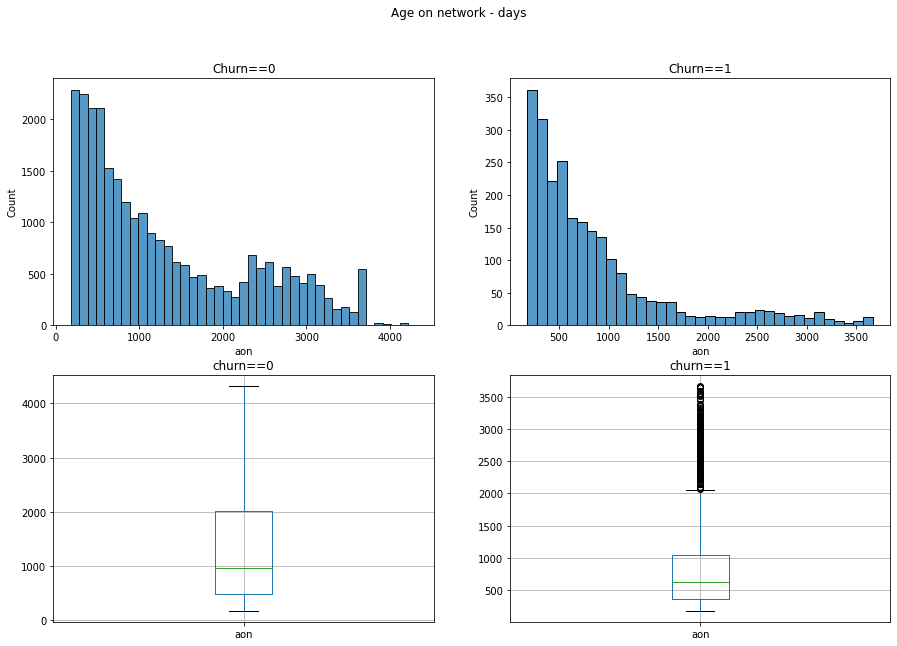

In [34]:
df_0 = df[df['churn']==0];print('df_0', df_0.shape[0])
df_1 = df[df['churn']==1];print('df_1', df_1.shape[0])

plt.figure(figsize=(15,10));plt.suptitle('Age on network - days')
ax = plt.subplot(2,2,1);sns.histplot(df_0, x='aon',ax=ax);ax.set_title("Churn==0")
ax = plt.subplot(2,2,2);sns.histplot(df_1, x='aon',ax=ax);ax.set_title("Churn==1"); print()

ax = plt.subplot(2,2,3);df_0.boxplot(column='aon', ax=ax); ax.set_title("churn==0")
ax = plt.subplot(2,2,4);df_1.boxplot(column='aon', ax=ax); ax.set_title("churn==1")

- Customers who do not churn have a typical aon - age on network of 1000 days
- Customers who churn have a typical on - age on network of 600 days

### Understand the groups of columns - ```Temporary```

In [35]:
listColumns(df)

171 ['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_og_mou_9', 'isd_og

In [36]:
COLS_NOT_PRESENT = []
for col in ['loc_ic_mou_6', 
'loc_ic_t2t_mou_6', 
'loc_ic_t2m_mou_6', 
'loc_ic_t2f_mou_6', 

'loc_og_mou_6', 
'loc_og_t2t_mou_6',
'loc_og_t2m_mou_6',
'loc_og_t2f_mou_6', 
'loc_og_t2c_mou_6', 

'std_ic_mou_6', 
'std_ic_t2t_mou_6',
'std_ic_t2m_mou_6', 
'std_ic_t2f_mou_6',
'std_ic_t2o_mou_6', 

'std_og_mou_6',
'std_og_t2t_mou_6', 
'std_og_t2m_mou_6',
'std_og_t2f_mou_6', 
'std_og_t2c_mou_6', 

'isd_ic_mou_6',
'isd_og_mou_6',

'spl_ic_mou_6', 
'spl_og_mou_6', 

'ic_others_6', 
'og_others_6',

'roam_ic_mou_6',
'roam_og_mou_6',
 
'onnet_mou_6', 
'offnet_mou_6', 

'count_rech_2g_6',
'count_rech_3g_6',

'total_rech_num_6',
'total_rech_amt_6', 
'total_rech_data_6', 

'max_rech_amt_6', 
'max_rech_data_6', 

'av_rech_amt_data_6', 

'date_of_last_rech_6',  
'date_of_last_rech_data_6', 
'last_day_rch_amt_6',  
'last_date_of_month_6', 

'vol_2g_mb_6',
'vol_3g_mb_6',

'total_ic_mou_6', 
'total_og_mou_6',

'arpu_6', 

'sachet_2g_6', 
'sachet_3g_6',
'monthly_2g_6',
'monthly_3g_6', 
'night_pck_user_6', ]:
    if col not in df.columns:
        COLS_NOT_PRESENT.append(col[:-1])
        print(col)
print(COLS_NOT_PRESENT)

std_ic_t2o_mou_6
std_og_t2c_mou_6
count_rech_2g_6
count_rech_3g_6
total_rech_data_6
max_rech_data_6
av_rech_amt_data_6
date_of_last_rech_data_6
last_date_of_month_6
night_pck_user_6
['std_ic_t2o_mou_', 'std_og_t2c_mou_', 'count_rech_2g_', 'count_rech_3g_', 'total_rech_data_', 'max_rech_data_', 'av_rech_amt_data_', 'date_of_last_rech_data_', 'last_date_of_month_', 'night_pck_user_']


In [37]:
COLS = df.columns
for col in COLS_NOT_PRESENT:
    for mon in [6, 7, 8, 9]:
        col_mon = f"{col}{mon}"
        if col_mon not in COLS:
            print(col_mon)

std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8
std_ic_t2o_mou_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
count_rech_2g_6
count_rech_2g_7
count_rech_2g_8
count_rech_2g_9
count_rech_3g_6
count_rech_3g_7
count_rech_3g_8
count_rech_3g_9
total_rech_data_6
total_rech_data_7
total_rech_data_8
total_rech_data_9
max_rech_data_6
max_rech_data_7
max_rech_data_8
max_rech_data_9
av_rech_amt_data_6
av_rech_amt_data_7
av_rech_amt_data_8
av_rech_amt_data_9
date_of_last_rech_data_6
date_of_last_rech_data_7
date_of_last_rech_data_8
date_of_last_rech_data_9
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
night_pck_user_6
night_pck_user_7
night_pck_user_8
night_pck_user_9


'loc_ic_mou_6', 
'loc_ic_t2t_mou_6', 
'loc_ic_t2m_mou_6', 
'loc_ic_t2f_mou_6', 

'loc_og_mou_6', 
'loc_og_t2t_mou_6',
'loc_og_t2m_mou_6',
'loc_og_t2f_mou_6', 
'loc_og_t2c_mou_6', 

'std_ic_mou_6', 
'std_ic_t2t_mou_6'
'std_ic_t2m_mou_6', 
'std_ic_t2f_mou_6', 

'std_og_mou_6',
'std_og_t2t_mou_6', 
'std_og_t2m_mou_6',
'std_og_t2f_mou_6', 

'isd_ic_mou_6',
'isd_og_mou_6',

'spl_ic_mou_6', 
'spl_og_mou_6', 

'ic_others_6', 
'og_others_6',

'roam_ic_mou_6',
'roam_og_mou_6',
 
'onnet_mou_6', 
'offnet_mou_6', 

'total_rech_num_6',
'total_rech_amt_6', 

'max_rech_amt_6', 

'date_of_last_rech_6',  
'last_day_rch_amt_6',  

'vol_2g_mb_6',
'vol_3g_mb_6',

'total_ic_mou_6', 
'total_og_mou_6',

'arpu_6', 

'sachet_2g_6', 
'sachet_3g_6'
'monthly_2g_6',
'monthly_3g_6', 

In [38]:
COL_SCHEME = ['sachet_2g_6', 'sachet_3g_6','monthly_2g_6','monthly_3g_6']
print(100 * df[COL_SCHEME].isnull().sum()/df.shape[0])
for col in COL_SCHEME:
    print(col, len(df[col].unique()), df[col].unique())
df[COL_SCHEME].tail()

sachet_2g_6     0.0
sachet_3g_6     0.0
monthly_2g_6    0.0
monthly_3g_6    0.0
dtype: float64
sachet_2g_6 30 [ 0  4  1  3  7 12  5  2 10  8 16  9  6 19 11 22 14 20 13 17 18 25 21 32
 15 39 24 27 30 34]
sachet_3g_6 25 [ 0  1  3  8  2 10  5  4 13  7  6 29 16 18 12 11  9 23 14 19 15 21 22 17
 28]
monthly_2g_6 5 [0 2 1 3 4]
monthly_3g_6 12 [ 0  4  2  1  3  5  7  6  9  8 11 14]


,sachet_2g_6,sachet_3g_6,monthly_2g_6,monthly_3g_6
29720,1,0,0,0
29721,0,0,0,0
29722,1,0,0,0
29723,0,0,0,0
29724,1,1,0,1


In [39]:
for col in ['date_of_last_rech_6', 'last_day_rch_amt_6', ]:
    print(col, len(df[col].unique()))

date_of_last_rech_6 31
last_day_rch_amt_6 157


In [40]:
print(sorted(df['last_day_rch_amt_6'].unique().tolist()))
print(sorted(df['last_day_rch_amt_7'].unique().tolist()))

[0, 5, 7, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 58, 59, 60, 62, 65, 67, 68, 70, 75, 76, 77, 78, 86, 89, 90, 91, 95, 97, 98, 99, 100, 101, 102, 104, 107, 110, 116, 120, 125, 128, 145, 150, 152, 153, 154, 155, 169, 175, 179, 180, 194, 195, 198, 200, 201, 202, 215, 220, 225, 229, 230, 236, 250, 252, 269, 274, 279, 297, 300, 319, 325, 330, 339, 350, 351, 379, 390, 398, 399, 400, 410, 440, 455, 459, 500, 505, 550, 565, 599, 619, 650, 655, 750, 752, 755, 779, 790, 849, 855, 887, 951, 1000, 1001, 1010, 1050, 1098, 1100, 1255, 1479, 1500, 1555, 1580, 1649, 2000, 2010, 2100, 2199, 2933, 3010, 3100, 3299, 3350, 4010]
[0, 1, 4, 7, 9, 10, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 40, 41, 43, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 58, 59, 60, 62, 65, 66, 67, 68, 70, 75, 77, 78, 86, 90, 91, 95, 97, 98, 99, 100, 101, 102, 107, 108, 110

In [41]:
# 'total_ic_mou_6',
COLS_IC = ['loc_ic_mou_6', 'std_ic_mou_6', 'isd_ic_mou_6','spl_ic_mou_6', 'roam_ic_mou_6']#,'ic_others_6']
df_ = df[COLS_IC+['total_ic_mou_6']].copy()
df_['total_ic'] = df_[COLS_IC].sum(axis=1)
df_.head()

,loc_ic_mou_6,std_ic_mou_6,isd_ic_mou_6,spl_ic_mou_6,roam_ic_mou_6,total_ic_mou_6,total_ic
0,427.88,180.54,2.06,0.21,16.23,626.46,626.92
1,81.43,22.43,0.00,0.00,0.00,103.86,103.86
2,215.58,423.81,245.28,0.45,23.53,968.61,908.65
3,276.86,87.99,0.00,0.00,0.00,364.86,364.85
4,81.96,9.91,0.00,0.00,0.00,91.88,91.87


In [42]:
COLS_OG = ['loc_og_mou_6', 'std_og_mou_6', 'isd_og_mou_6','spl_og_mou_6', 'roam_og_mou_6','og_others_6']
df_ = df[COLS_OG+['total_og_mou_6']].copy()
df_['total_og'] = df_[COLS_OG].sum(axis=1)
(df_['total_og']-df_['total_og_mou_6']).head()

0    23.73
1    -0.01
2     7.98
3    -0.01
4    -0.02
dtype: float64

In [43]:
COLS_LOC_IC = getColumnsWithPrefix('loc_ic', COLS)
COLS_LOC_IC_6 = getColumnsWithSuffix('_6', COLS_LOC_IC)
df_ = df[COLS_LOC_IC_6].copy()
df_['total_loc_ic'] = df_[['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum(axis=1)
df_.head()

16 ['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9']
4 ['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6']


,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,total_loc_ic
0,58.14,217.56,152.16,427.88,427.86
1,23.84,57.58,0.00,81.43,81.42
2,67.88,142.88,4.81,215.58,215.57
3,41.33,226.81,8.71,276.86,276.85
4,34.54,47.41,0.00,81.96,81.95


- 'loc_ic_mou_6' is sum of 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6','loc_ic_t2f_mou_6'. So should we drop the rest of the columns?

In [44]:
COLS_LOC_STD = getColumnsWithPrefix('std_og', COLS)
COLS_LOC_STD_6 = getColumnsWithSuffix('_6', COLS_LOC_STD)
df_ = df[COLS_LOC_STD_6].copy()
df_['total_std_og'] = df_[['std_og_t2t_mou_6', 'std_og_t2m_mou_6','std_og_t2f_mou_6']].sum(axis=1)
df_.head()

16 ['std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_og_mou_9']
4 ['std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6']


,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,total_std_og
0,4.30,49.89,6.66,60.86,60.85
1,116.56,13.69,0.00,130.26,130.25
2,446.41,255.36,0.00,701.78,701.77
3,7.89,22.99,0.00,30.89,30.88
4,1146.91,1.55,0.00,1148.46,1148.46


In [45]:
# ONNET
# 'onnet_mou_6',
COLS_ONNET = [
        'loc_ic_t2t_mou_6', 'loc_ic_t2f_mou_6', 
        'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6',
        'std_ic_t2t_mou_6', 'std_ic_t2f_mou_6',
        'std_og_t2t_mou_6','std_og_t2f_mou_6', 
        ]
COLS_ONNET_6 = getColumnsWithSuffix('_6', COLS_ONNET)
df_ = df[COLS_ONNET_6 + ['onnet_mou_6']].copy()
df_['total_onnet'] = df_[COLS_ONNET_6].sum(axis=1)
df_.head()

9 ['loc_ic_t2t_mou_6', 'loc_ic_t2f_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2f_mou_6', 'std_og_t2t_mou_6', 'std_og_t2f_mou_6']


,loc_ic_t2t_mou_6,loc_ic_t2f_mou_6,loc_og_t2t_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,std_ic_t2t_mou_6,std_ic_t2f_mou_6,std_og_t2t_mou_6,std_og_t2f_mou_6,onnet_mou_6,total_onnet
0,58.14,152.16,51.39,62.13,0.0,36.89,52.19,4.30,6.66,57.84,423.86
1,23.84,0.00,297.13,0.00,0.0,0.00,0.00,116.56,0.00,413.69,437.53
2,67.88,4.81,49.63,4.54,0.0,115.68,0.00,446.41,0.00,501.76,688.95
3,41.33,8.71,42.61,0.00,0.0,68.79,0.51,7.89,0.00,50.51,169.84
4,34.54,0.00,38.99,0.00,0.0,8.63,0.00,1146.91,0.00,1185.91,1229.07


In [46]:
# OFFNET
df[['offnet_mou_6', 'loc_ic_t2m_mou_6', 'loc_og_t2m_mou_6', 'std_ic_t2m_mou_6', 'std_og_t2m_mou_6',]].head()

,offnet_mou_6,loc_ic_t2m_mou_6,loc_og_t2m_mou_6,std_ic_t2m_mou_6,std_og_t2m_mou_6
0,453.43,217.56,308.63,91.44,49.89
1,94.66,57.58,80.96,22.43,13.69
2,413.31,142.88,151.13,308.13,255.36
3,296.29,226.81,273.29,18.68,22.99
4,61.64,47.41,58.54,1.28,1.55


In [47]:
# Check if all the months have equal number of columns
getColumnsWithSuffix('_6', COLS);getColumnsWithSuffix('_7', COLS);getColumnsWithSuffix('_8', COLS);getColumnsWithSuffix('_9', COLS);print()

41 ['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'date_of_last_rech_6', 'last_day_rch_amt_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6']
41 ['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_

# Remove the month 9 columns

In [48]:
cols_month_9 = getColumnsWithSuffix('_9', COLS)
print("DF SHAPE:", df.shape, end=' --> ')
COLS = list(set(COLS) - set(cols_month_9))
df = df[COLS]
print(' --> ', df.shape)

41 ['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9']
DF SHAPE: (29725, 171) -->  -->  (29725, 130)


<Figure size 720x432 with 0 Axes>

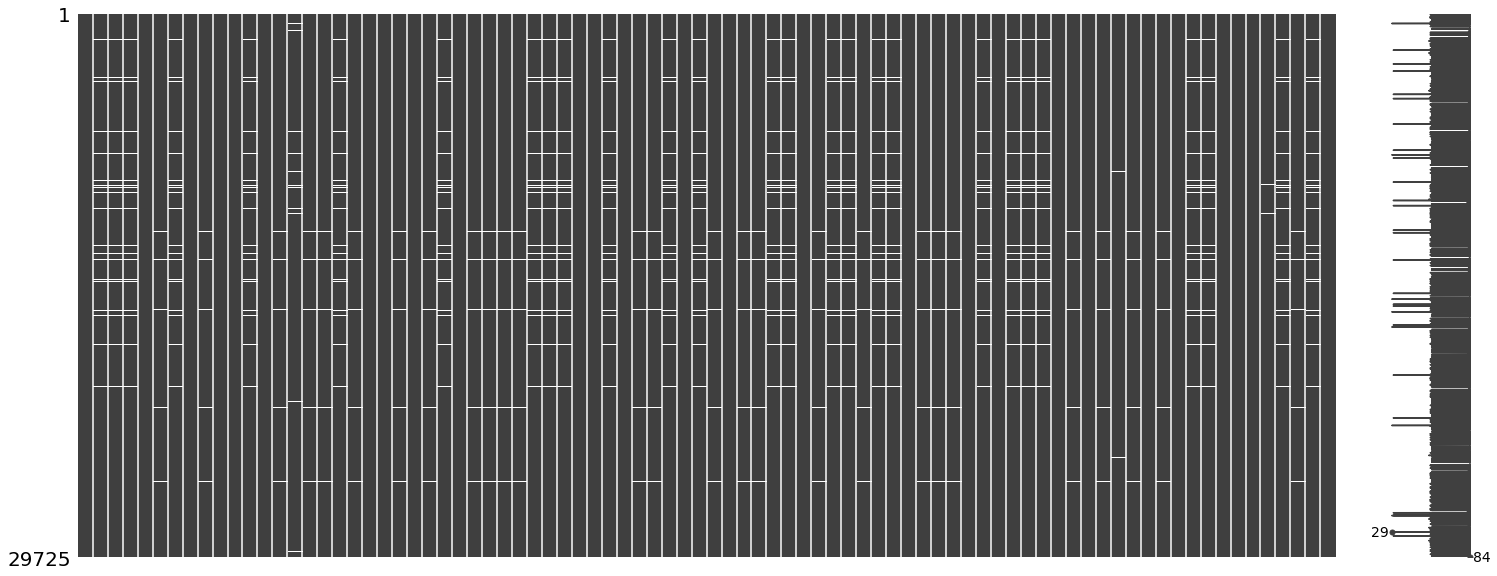

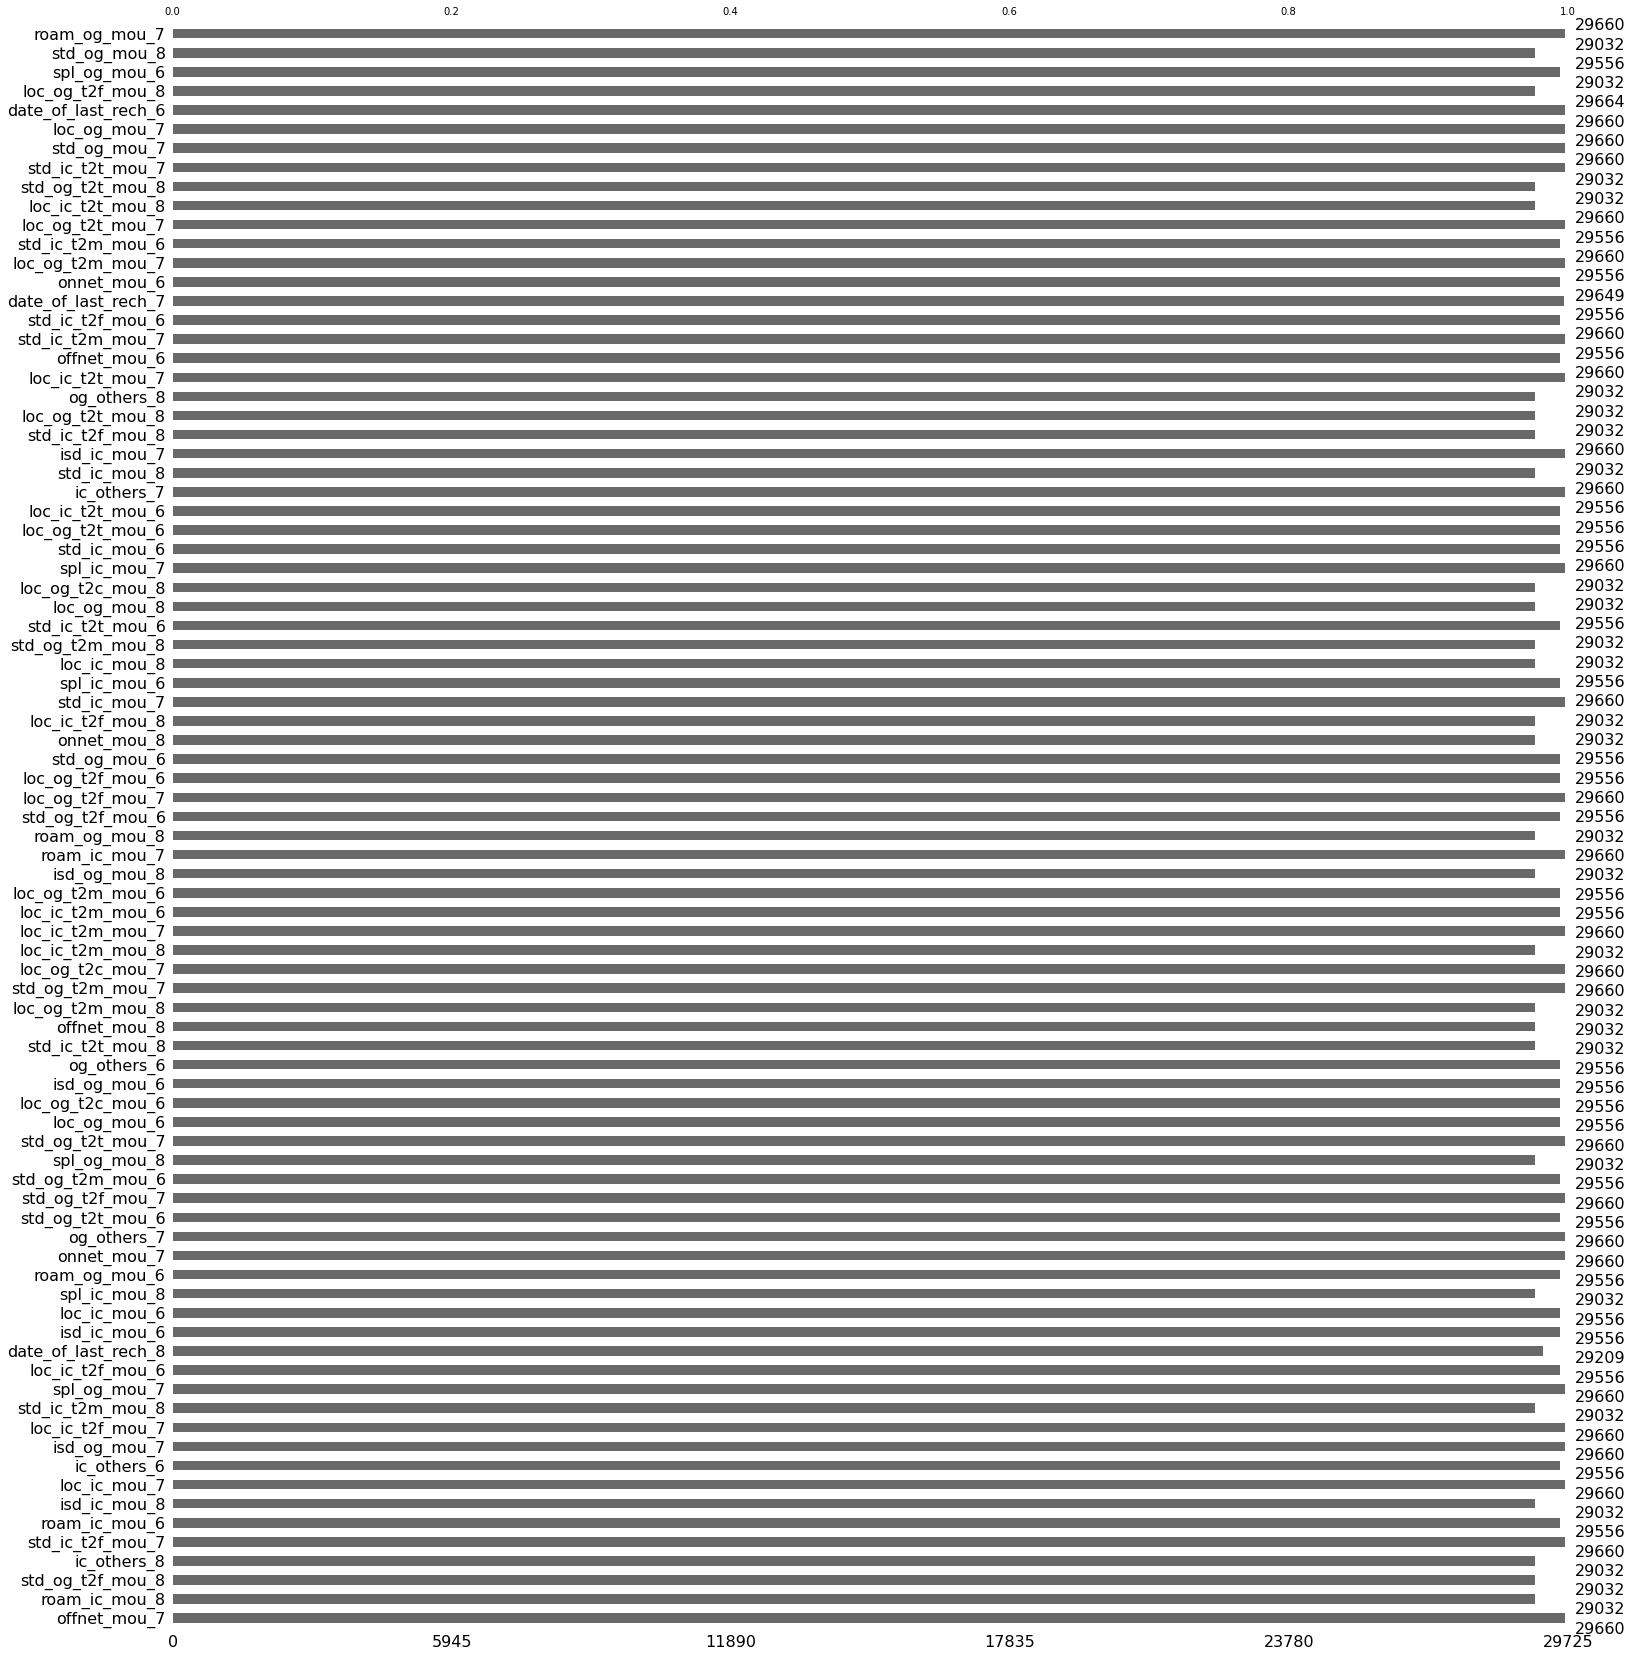

Columns with missing data: 84 64.62%
roam_ic_mou_8, std_og_t2f_mou_8, ic_others_8, isd_ic_mou_8, std_ic_t2m_mou_8, spl_ic_mou_8, spl_og_mou_8, std_ic_t2t_mou_8, offnet_mou_8, loc_og_t2m_mou_8, loc_ic_t2m_mou_8, isd_og_mou_8, roam_og_mou_8, onnet_mou_8, loc_ic_t2f_mou_8, loc_ic_mou_8, std_og_t2m_mou_8, loc_og_mou_8, loc_og_t2c_mou_8, std_ic_mou_8, std_ic_t2f_mou_8, loc_og_t2t_mou_8, og_others_8, loc_ic_t2t_mou_8, std_og_t2t_mou_8, loc_og_t2f_mou_8, std_og_mou_8, date_of_last_rech_8, roam_ic_mou_6, ic_others_6, loc_ic_t2f_mou_6, isd_ic_mou_6, loc_ic_mou_6, roam_og_mou_6, std_og_t2t_mou_6, std_og_t2m_mou_6, loc_og_mou_6, loc_og_t2c_mou_6, isd_og_mou_6, og_others_6, loc_ic_t2m_mou_6, loc_og_t2m_mou_6, std_og_t2f_mou_6, loc_og_t2f_mou_6, std_og_mou_6, spl_ic_mou_6, std_ic_t2t_mou_6, std_ic_mou_6, loc_og_t2t_mou_6, loc_ic_t2t_mou_6, offnet_mou_6, std_ic_t2f_mou_6, onnet_mou_6, std_ic_t2m_mou_6, spl_og_mou_6, date_of_last_rech_7, offnet_mou_7, std_ic_t2f_mou_7, loc_ic_mou_7, isd_og_mou_7, loc

In [49]:
displayColumnsWithMissingData(df)
COLS_MISS = listColumsWithMissingData(df, 0)
[print(col[0], end=', ') for col in COLS_MISS];print()

In [50]:
sum(df.isnull().values.any(axis=1))

1270

Columns with categorical values 3 --> ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
3 1
date_of_last_rech_8         : [32] --> ['8/26/2014', '8/30/2014', '8/14/2014', '8/25/2014', '8/31/2014', '8/24/2014', '8/28/2014', '8/27/2014', '8/23/2014', '8/21/2014', '8/29/2014', '8/17/2014', '8/22/2014', '8/19/2014', nan, '8/15/2014', '8/9/2014', '8/20/2014', '8/8/2014', '8/10/2014', '8/16/2014', '8/12/2014', '8/11/2014', '8/13/2014', '8/18/2014', '8/1/2014', '8/2/2014', '8/5/2014', '8/6/2014', '8/3/2014', '8/4/2014', '8/7/2014']
date_of_last_rech_7         : [32] --> ['7/25/2014', '7/31/2014', '7/22/2014', '7/30/2014', '7/17/2014', '7/28/2014', '7/23/2014', '7/26/2014', '7/29/2014', '7/27/2014', '7/19/2014', '7/20/2014', '7/7/2014', '7/24/2014', '7/15/2014', '7/9/2014', '7/13/2014', '7/18/2014', '7/16/2014', '7/21/2014', nan, '7/5/2014', '7/12/2014', '7/11/2014', '7/10/2014', '7/1/2014', '7/14/2014', '7/6/2014', '7/8/2014', '7/2/2014', '7/4/2014', '7/3/2014']
date_of_la

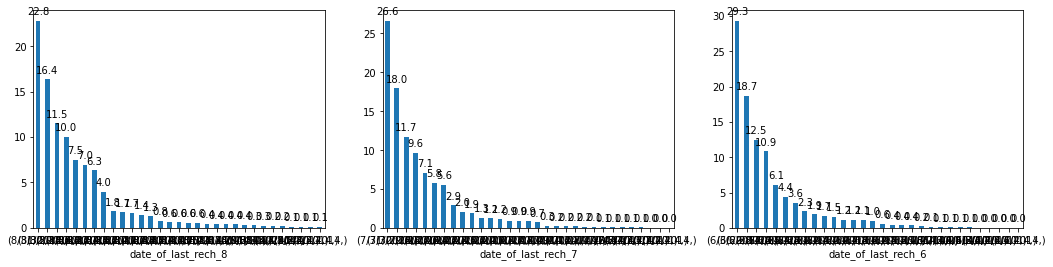

In [51]:
COLS_CAT = getCategoricalColumns(df)
plotCategoricalVariables(df, COLS_CAT, "")

The columns date_of_last_rech_<mon> have the complete date. Month and year are redundant as they are same for all the rows. Let's just store the day alone.

In [52]:
for mon in [6,7,8]:
    col = f'date_of_last_rech_{mon}';print(col)
    print(df[col].unique())
    df[col] = df[col].apply(pd.to_datetime)
    df[col] = df[col].dt.day
    print(df[col].unique())

date_of_last_rech_6
['6/27/2014' '6/25/2014' '6/20/2014' '6/30/2014' '6/23/2014' '6/24/2014'
 '6/29/2014' '6/28/2014' '6/26/2014' '6/21/2014' '6/17/2014' '6/22/2014'
 '6/13/2014' '6/16/2014' '6/12/2014' '6/15/2014' '6/18/2014' '6/8/2014'
 '6/19/2014' '6/2/2014' '6/7/2014' '6/4/2014' '6/14/2014' '6/11/2014' nan
 '6/9/2014' '6/10/2014' '6/3/2014' '6/5/2014' '6/1/2014' '6/6/2014']
[27. 25. 20. 30. 23. 24. 29. 28. 26. 21. 17. 22. 13. 16. 12. 15. 18.  8.
 19.  2.  7.  4. 14. 11. nan  9. 10.  3.  5.  1.  6.]
date_of_last_rech_7
['7/25/2014' '7/31/2014' '7/22/2014' '7/30/2014' '7/17/2014' '7/28/2014'
 '7/23/2014' '7/26/2014' '7/29/2014' '7/27/2014' '7/19/2014' '7/20/2014'
 '7/7/2014' '7/24/2014' '7/15/2014' '7/9/2014' '7/13/2014' '7/18/2014'
 '7/16/2014' '7/21/2014' nan '7/5/2014' '7/12/2014' '7/11/2014'
 '7/10/2014' '7/1/2014' '7/14/2014' '7/6/2014' '7/8/2014' '7/2/2014'
 '7/4/2014' '7/3/2014']
[25. 31. 22. 30. 17. 28. 23. 26. 29. 27. 19. 20.  7. 24. 15.  9. 13. 18.
 16. 21. nan  5. 12. 11. 

3 1
date_of_last_rech_8         : [32] --> [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, nan]
date_of_last_rech_7         : [32] --> [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, nan]
date_of_last_rech_6         : [31] --> [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, nan]


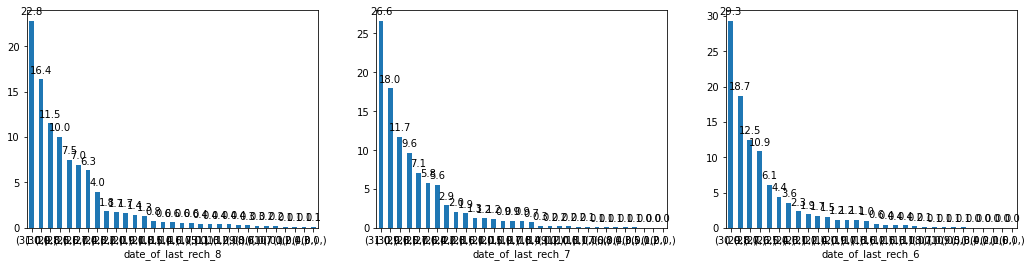

In [53]:
plotCategoricalVariables(df, COLS_CAT, "")

In [54]:
COLS_NUM = getNumericalColumns(df)
plotNumericalVariables(df, COLS_NUM, "")
plotBoxPlots(df, COLS_NUM)

Columns with numerical values 130 --> ['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'aug_vbc_3g', 'avg_rech_amt_67', 'churn', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'monthly

1. Categorical variables: Impute with mode
    - Towards the end of the month the recharge is higher
2. Numerical Variables 
    - w/o outliers: 'aon', 'isd_lc_mou_6', 'lou_lc_mou_6'. The missing values in these columns can be imputed with mean. 
    - Rest (with outliers) should be imputed with median values

In [ ]:
print("DF SHAPE", df.shape, end='')
print("Before", df.isnull().sum().sum())

for column in COLS_MISS:
    col = column[0]
    if df[col].dtype == np.float64:
        if col in ['aon', 'isd_lc_mou_6', 'lou_lc_mou_6']:
            print(col)
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    elif df[col].dtype == 'object':
        #print(col,  df[col].dtype, df[col].mode().values[0])
        df[col].fillna(df[col].mode().values[0], inplace=True)

print("After", df.isnull().sum().sum())
print("-->", df.shape)

DF SHAPE (29725, 130)Before 25682
After 0
--> (29725, 130)


# Pre-process data
- Impute Missing value
- Handle Outliers - TODO
- Create Dummy variables - TODO: date_of_last_rech_6

# Derive new features

1. avg_rech_amt_67: average average recharge amount in the good phase (months 6 & 7)
2. 'vol_mb_67', 'vol_mb_78': Difference in the internet usage between the months 6,7 & 8
3. 'total_mou_67', 'total_mou_78': Difference in the calls between the months 6,7 & 8
4. 'arpu67', 'arpu_78': Difference in the revenue between the months 6,7 & 8

In [ ]:
df['vol_mb_6'] = df['vol_2g_mb_6'] + df['vol_3g_mb_6']
df['vol_mb_7'] = df['vol_2g_mb_7'] + df['vol_3g_mb_7']
df['vol_mb_8'] = df['vol_2g_mb_8'] + df['vol_3g_mb_8']
df['vol_mb'] = df['vol_mb_6'] + df['vol_mb_7'] + df['vol_mb_8']
df['vol_mb_67'] = df['vol_mb_7'] - df['vol_mb_6']
df['vol_mb_78'] = df['vol_mb_8'] - df['vol_mb_7']

In [ ]:
df['total_mou_6'] = df['total_ic_mou_6'] + df['total_og_mou_6']
df['total_mou_7'] = df['total_ic_mou_7'] + df['total_og_mou_7']
df['total_mou_8'] = df['total_ic_mou_8'] + df['total_og_mou_8']
df['total_mou'] = df['total_mou_6'] + df['total_mou_7'] + df['total_mou_8']
df['total_mou_67'] = df['total_mou_7'] - df['total_mou_6']
df['total_mou_78'] = df['total_mou_8'] - df['total_mou_7']

In [ ]:
df['arpu_67'] = df['arpu_7'] - df['arpu_6']
df['arpu_78'] = df['arpu_8'] - df['arpu_7']

In [ ]:
df[['arpu_67', 'arpu_78']].head()

,arpu_67,arpu_78
0,280.670,1821.630
1,113.502,-354.861
2,-287.175,387.589
3,-131.106,-111.975
4,-671.028,6.519


,churn,67,78
vol_mb,0,25.2,-6.2
total_mou,0,55.4,-60.4
arpu,0,14.3,-30.4
vol_mb,1,-31.5,-127.7
total_mou,1,-197.9,-615.1
arpu,1,-84.7,-319.9


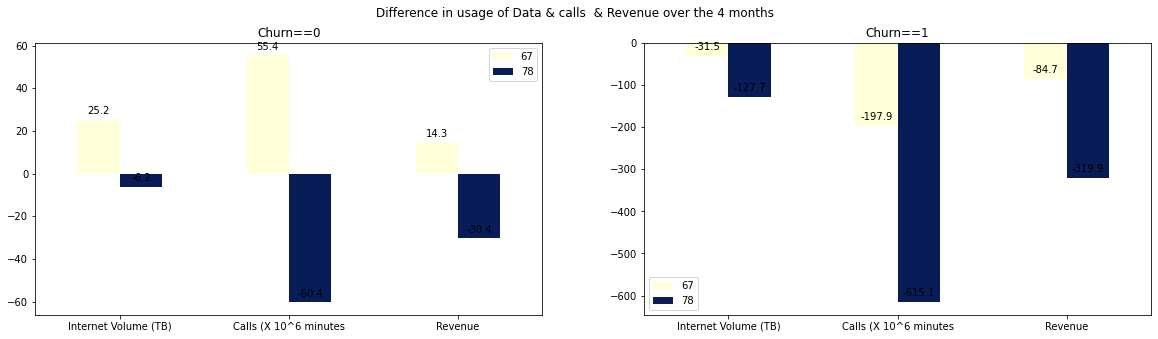

In [ ]:
COLS_ = ['vol_mb', 'total_mou', 'arpu']

df_0 = pd.DataFrame(columns=COLS_) 
df_1 = pd.DataFrame(columns=COLS_)
for mon in [67, 78]:
    for col in COLS_:
        #print(mon, f'{col}_{mon}', int(df[f'{col}_{mon}'].mean()), int(df[f'{col}_{mon}'].median()))
        df_0.loc[f'{mon}', col] = df[df['churn']==0][f'{col}_{mon}'].mean().round(1)
        df_1.loc[f'{mon}', col] = df[df['churn']==1][f'{col}_{mon}'].mean().round(1)

COLS_USAGE_REVENUE = ['Internet Volume (TB)', 'Calls (X 10^6 minutes', 'Revenue']
df_0 = df_0.transpose()
df_1 = df_1.transpose()

fig = plt.figure(figsize=(20,5)); fig.suptitle("Difference in usage of Data & calls  & Revenue over the 4 months")
ax = plt.subplot(1,2,1); ax = df_0.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==0"); ax.set_xticklabels(COLS_USAGE_REVENUE, rotation=0)
ax = plt.subplot(1,2,2); ax = df_1.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==1"); ax.set_xticklabels(COLS_USAGE_REVENUE, rotation=0)
print()

df_0['churn'] = 0
df_1['churn'] = 1
pd.concat([df_0,df_1])[['churn','67','78']]

In [ ]:
COLS = df.columns.tolist()

In [ ]:
listColumns(df)

144 ['roam_og_mou_8', 'isd_og_mou_7', 'total_og_mou_7', 'total_rech_num_7', 'isd_ic_mou_6', 'std_ic_mou_8', 'last_day_rch_amt_6', 'loc_og_t2f_mou_6', 'std_og_mou_6', 'std_og_t2f_mou_8', 'monthly_3g_7', 'spl_og_mou_6', 'loc_ic_mou_8', 'max_rech_amt_8', 'monthly_2g_7', 'total_og_mou_8', 'std_ic_t2f_mou_6', 'offnet_mou_8', 'std_ic_t2t_mou_6', 'avg_rech_amt_67', 'loc_ic_t2f_mou_8', 'std_og_mou_7', 'vol_2g_mb_7', 'total_ic_mou_6', 'std_ic_t2t_mou_8', 'loc_og_t2m_mou_7', 'std_og_t2m_mou_7', 'total_rech_amt_8', 'isd_ic_mou_8', 'loc_ic_t2t_mou_7', 'offnet_mou_6', 'sep_vbc_3g', 'spl_og_mou_7', 'og_others_8', 'loc_ic_mou_6', 'total_og_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_7', 'roam_og_mou_7', 'ic_others_8', 'loc_og_mou_7', 'isd_og_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2m_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_7', 'std_og_t2f_mou_7', 'max_rech_amt_7', 'sachet_3g_7', 'isd_ic_mou_7', 'spl_og_mou_8', 'loc_og_t2c_mou_6', 'last_day_rch_amt_8', 'monthly_3g_8', 'total_rech_amt_7', 'std_ic_t2m_mou_

In [ ]:
df.shape

(29725, 144)

# Prepare data

# Model to predict customers who will churn - with PCA

# Model to identify indicators of churn - w/o PCA